In [2]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [3]:
nltk.download('wordnet', "/kaggle/working/nltk_data/")
nltk.download('omw-1.4', "/kaggle/working/nltk_data/")
! unzip /kaggle/working/nltk_data/corpora/wordnet.zip -d /kaggle/working/nltk_data/corpora
! unzip /kaggle/working/nltk_data/corpora/omw-1.4.zip -d /kaggle/working/nltk_data/corpora
nltk.data.path.append("/kaggle/working/nltk_data/")

[nltk_data] Downloading package wordnet to
[nltk_data]     /kaggle/working/nltk_data/...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /kaggle/working/nltk_data/...


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Archive:  /kaggle/working/nltk_data/corpora/wordnet.zip
   creating: /kaggle/working/nltk_data/corpora/wordnet/
  inflating: /kaggle/working/nltk_data/corpora/wordnet/lexnames  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/data.verb  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/index.adv  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/adv.exc  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/index.verb  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/data.adj  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/index.adj  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/LICENSE  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/citation.bib  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/noun.exc  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/verb.exc  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/README  
  inflating: /kaggle/w

In [5]:
# Ensure you have the necessary NLTK data files
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
# Load data
df = pd.read_csv('/kaggle/input/emotions/text.csv') 

In [7]:
df

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4
...,...,...,...
416804,416804,i feel like telling these horny devils to find...,2
416805,416805,i began to realize that when i was feeling agi...,3
416806,416806,i feel very curious be why previous early dawn...,5
416807,416807,i feel that becuase of the tyranical nature of...,3


In [8]:
df.shape

(416809, 3)

In [9]:
df.isnull().sum()

Unnamed: 0    0
text          0
label         0
dtype: int64

In [12]:
df.duplicated().sum()

0

In [17]:
df.describe()

,Unnamed: 0,label
count,416809.000000,416809.000000
mean,208404.000000,1.554271
std,120322.538513,1.490453
min,0.000000,0.000000
25%,104202.000000,0.000000
50%,208404.000000,1.000000
75%,312606.000000,3.000000
max,416808.000000,5.000000


In [18]:
def preprocess_text(text):
    text = text.lower()  # Lowercase the text
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\b\w{1,2}\b', '', text)  # Remove short words
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    
    stop_words = set(stopwords.words('english')) - {'not', 'no', 'nor'}  # Remove stopwords except negations
    lemmatizer = WordNetLemmatizer()
    
    # Tokenize text to handle negations like isn't, wasn't, aren't, etc.
    tokens = nltk.word_tokenize(text)
    tokens_lemmatized = []
    
    for token in tokens:
        if token in stop_words:
            continue
        if token in ['not', 'no', 'nor']:
            tokens_lemmatized.append(token)
        elif token.endswith("n't"):
            tokens_lemmatized.append(token)  # Keep contractions like "isn't"
        else:
            tokens_lemmatized.append(lemmatizer.lemmatize(token))
    
    text = ' '.join(tokens_lemmatized)
    
    return text

In [19]:
df['preprocessed_text'] = df['text'].apply(preprocess_text)

In [21]:
df.head(30)

,Unnamed: 0,text,label,preprocessed_text
0,0,i just feel really helpless and heavy hearted,4,feel really helpless heavy hearted
1,1,ive enjoyed being able to slouch about relax a...,0,ive enjoyed able slouch relax unwind frankly n...
2,2,i gave up my internship with the dmrg and am f...,4,gave internship dmrg feeling distraught
3,3,i dont know i feel so lost,0,dont know feel lost
4,4,i am a kindergarten teacher and i am thoroughl...,4,kindergarten teacher thoroughly weary job take...
5,5,i was beginning to feel quite disheartened,0,beginning feel quite disheartened
6,6,i would think that whomever would be lucky eno...,2,would think whomever would lucky enough stay s...
7,7,i fear that they won t ever feel that deliciou...,1,fear ever feel delicious excitement christmas ...
8,8,im forever taking some time out to have a lie ...,5,forever taking time lie feel weird
9,9,i can still lose the weight without feeling de...,0,still lose weight without feeling deprived


In [22]:
# Compute dynamic parameters
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(df['preprocessed_text'])
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1  # +1 for padding token
maxlen = max([len(x.split()) for x in df['preprocessed_text']])

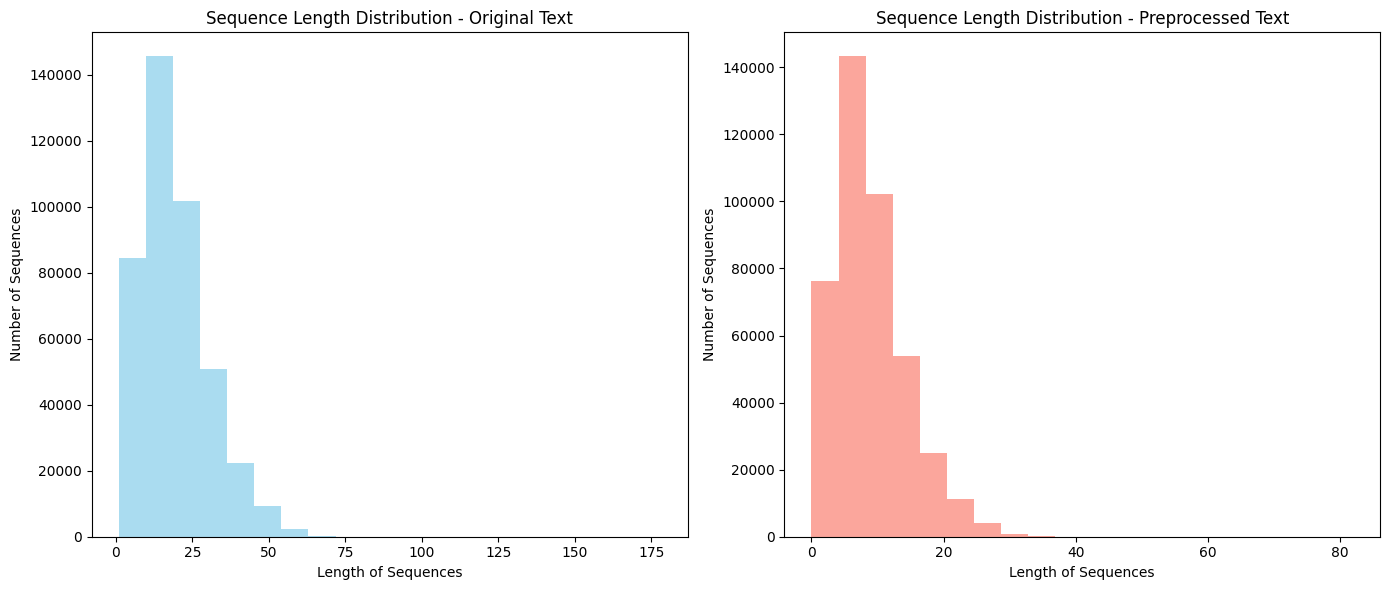

In [23]:
# Visualize sequence length distribution for original and preprocessed text
plt.figure(figsize=(14, 6))

# Original Text
plt.subplot(1, 2, 1)
plt.hist([len(sent.split()) for sent in df['text']], bins=20, color='skyblue', alpha=0.7)
plt.title('Sequence Length Distribution - Original Text')
plt.xlabel('Length of Sequences')
plt.ylabel('Number of Sequences')

# Preprocessed Text
plt.subplot(1, 2, 2)
plt.hist([len(sent.split()) for sent in df['preprocessed_text']], bins=20, color='salmon', alpha=0.7)
plt.title('Sequence Length Distribution - Preprocessed Text')
plt.xlabel('Length of Sequences')
plt.ylabel('Number of Sequences')

plt.tight_layout()
plt.show()

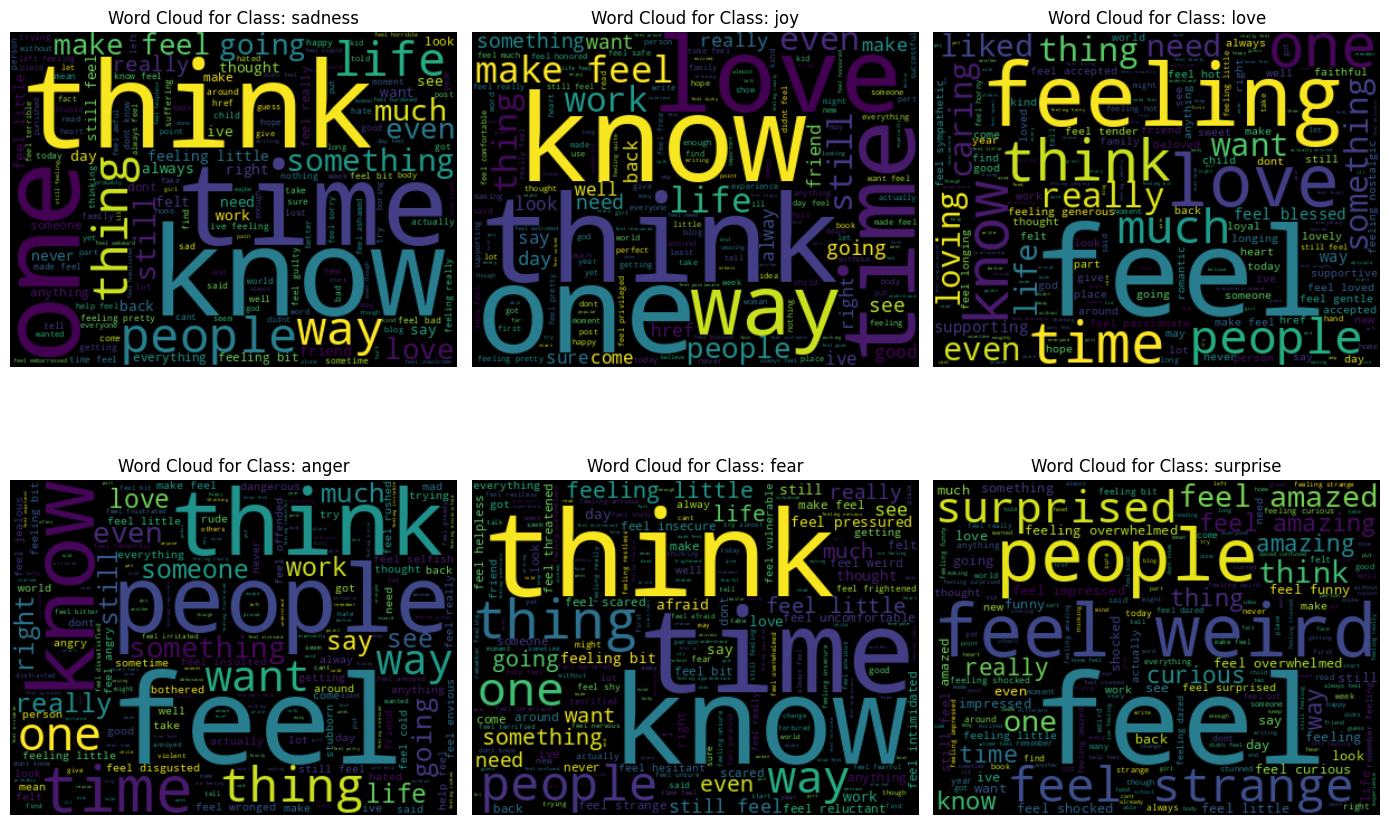

In [24]:
# Generate word clouds for each class
class_names = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

plt.figure(figsize=(14, 10))
for i, class_name in enumerate(class_names):
    plt.subplot(2, 3, i + 1)
    text_class = ' '.join(df[df['label'] == i]['preprocessed_text'])
    wordcloud = WordCloud(width=400, height=300, random_state=21, max_font_size=110).generate(text_class)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(f'Word Cloud for Class: {class_name}')
    plt.axis('off')

plt.tight_layout()
plt.show()

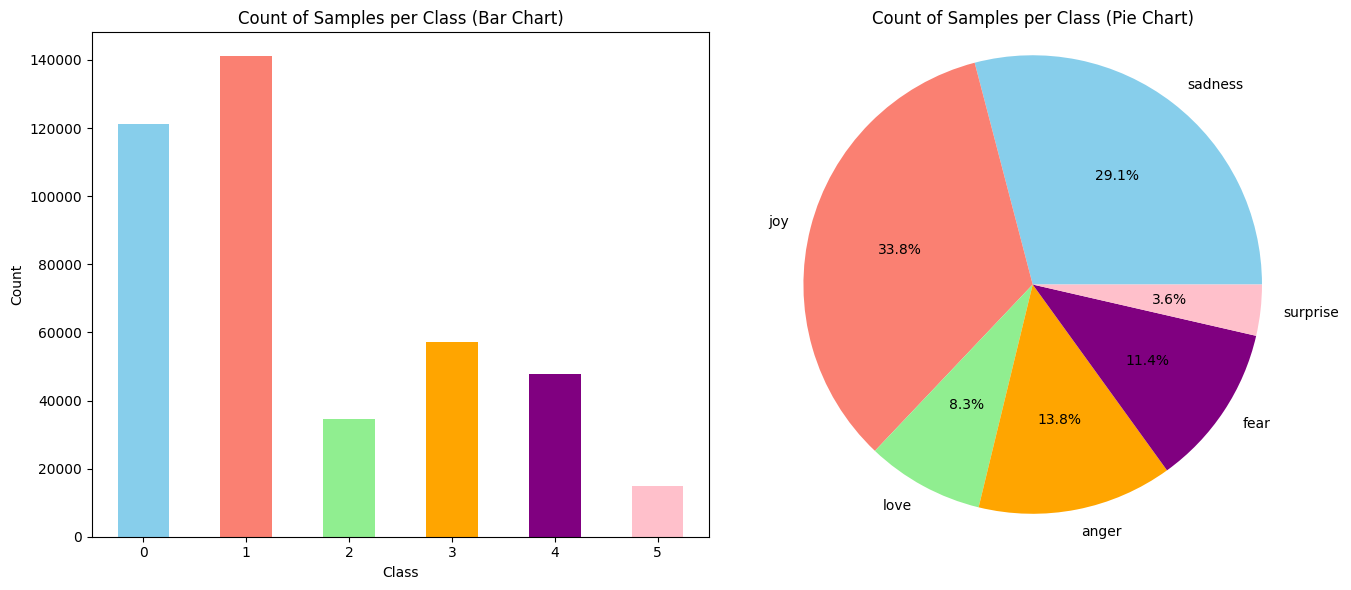

In [29]:
# Plot count of samples per class (Bar chart and Pie chart)
plt.figure(figsize=(14, 6))

# Bar chart
plt.subplot(1, 2, 1)
df['label'].value_counts().sort_index().plot(kind='bar', color=['skyblue', 'salmon', 'lightgreen', 'orange', 'purple', 'pink'])
plt.title('Count of Samples per Class (Bar Chart)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)

# Pie chart
plt.subplot(1, 2, 2)
plt.pie(df['label'].value_counts().sort_index(), labels=class_names, autopct='%1.1f%%', colors=['skyblue', 'salmon', 'lightgreen', 'orange', 'purple', 'pink'])
plt.title('Count of Samples per Class (Pie Chart)')
plt.axis('equal')

plt.tight_layout()
plt.show()


In [35]:
# Encode labels
labels = to_categorical(df['label'], num_classes=6)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(df['preprocessed_text'], labels, test_size=0.2, random_state=42)

# Tokenize and pad the text data
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)


In [36]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(333447, 82) (333447, 6)
(83362, 82) (83362, 6)


In [37]:
# Transformer Encoder layer
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, heads, neurons):
        super(TransformerEncoder, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [layers.Dense(neurons, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(0.5)
        self.dropout2 = layers.Dropout(0.5)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs, training=training)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1, training=training)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [38]:
# Token and Position Embedding layer
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions


In [39]:
# Define the model with Transformer layer
embed_dim = 100  
heads = 10 
neurons = 64

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerEncoder(embed_dim, heads, neurons)
x = transformer_block(x, training=True)  # Ensure training=True is passed
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.35)(x)
outputs = layers.Dense(6, activation="softmax")(x)  # 6 classes with softmax activation
model = Model(inputs=inputs, outputs=outputs)

In [40]:
# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Print model summary
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 82)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding_1  │ (None, 82, 100)        │     6,729,700 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_1           │ (None, 82, 100)        │       416,464 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 100)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,146,770 (27.26 MB)

 Trainable params: 7,146,770 (27.26 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
# Train the model
history = model.fit(X_train, y_train, epochs=40, batch_size=1024, validation_split=0.2, verbose=1)

Epoch 1/40


I0000 00:00:1718543218.300799     258 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718543218.318299     258 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.2990 - loss: 1.7945

W0000 00:00:1718543272.581766     256 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


261/261 ━━━━━━━━━━━━━━━━━━━━ 74s 231ms/step - accuracy: 0.2991 - loss: 1.7939 - val_accuracy: 0.3363 - val_loss: 1.6055
Epoch 2/40


W0000 00:00:1718543278.666120     259 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


261/261 ━━━━━━━━━━━━━━━━━━━━ 53s 202ms/step - accuracy: 0.4095 - loss: 1.4167 - val_accuracy: 0.9089 - val_loss: 0.2072
Epoch 3/40
261/261 ━━━━━━━━━━━━━━━━━━━━ 52s 199ms/step - accuracy: 0.9132 - loss: 0.1754 - val_accuracy: 0.9099 - val_loss: 0.1980
Epoch 4/40
261/261 ━━━━━━━━━━━━━━━━━━━━ 52s 199ms/step - accuracy: 0.9188 - loss: 0.1582 - val_accuracy: 0.9096 - val_loss: 0.1914
Epoch 5/40
261/261 ━━━━━━━━━━━━━━━━━━━━ 52s 198ms/step - accuracy: 0.9222 - loss: 0.1486 - val_accuracy: 0.9068 - val_loss: 0.2048
Epoch 6/40
261/261 ━━━━━━━━━━━━━━━━━━━━ 52s 200ms/step - accuracy: 0.9250 - loss: 0.1424 - val_accuracy: 0.9016 - val_loss: 0.2223
Epoch 7/40
261/261 ━━━━━━━━━━━━━━━━━━━━ 52s 200ms/step - accuracy: 0.9330 - loss: 0.1278 - val_accuracy: 0.8973 - val_loss: 0.2555
Epoch 8/40
261/261 ━━━━━━━━━━━━━━━━━━━━ 52s 200ms/step - accuracy: 0.9372 - loss: 0.1197 - val_accuracy: 0.8951 - val_loss: 0.2791
Epoch 9/40
261/261 ━━━━━━━━━━━━━━━━━━━━ 52s 199ms/step - accuracy: 0.9405 - loss: 0.1119 - val

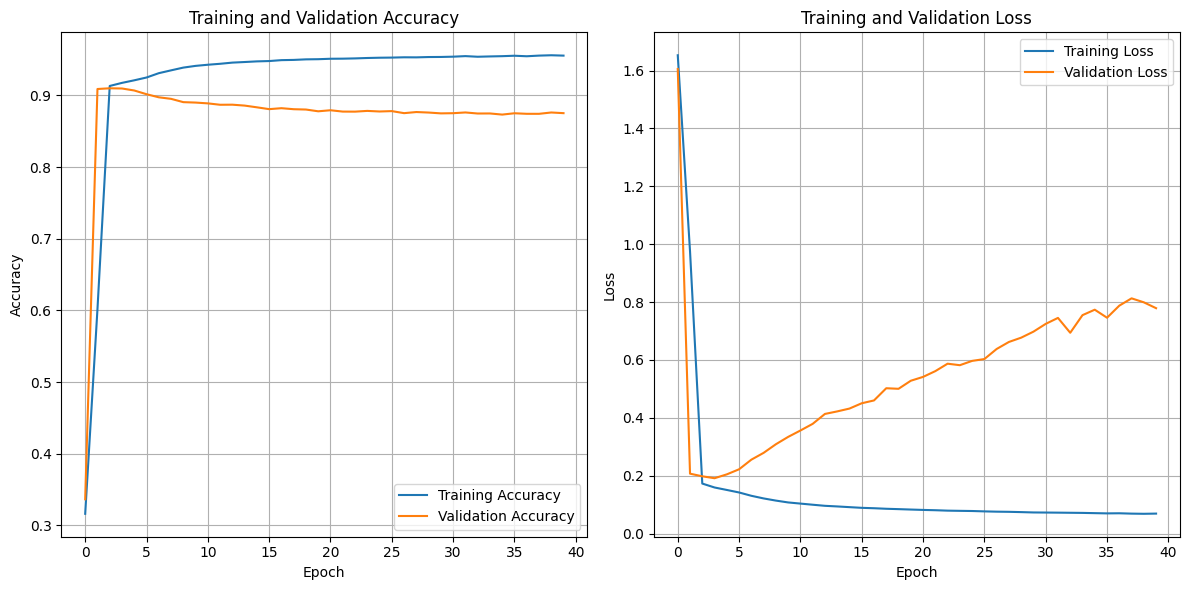

In [44]:
# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

plot_history(history)

In [45]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

  54/2606 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8694 - loss: 0.8705 

W0000 00:00:1718545408.454840     258 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2606/2606 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8755 - loss: 0.7767
Test Loss: 0.7772
Test Accuracy: 0.8761


In [46]:
# Evaluate the model and get predictions
y_pred = model.predict(X_test)
y_pred_classes = tf.argmax(y_pred, axis=1)
y_true = tf.argmax(y_test, axis=1)

# Print classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=class_names ))

  52/2606 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step 

W0000 00:00:1718545422.420838     256 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2606/2606 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step

Classification Report:

              precision    recall  f1-score   support

     sadness       0.92      0.93      0.93     24201
         joy       0.92      0.88      0.90     28164
        love       0.71      0.83      0.76      6929
       anger       0.89      0.88      0.88     11441
        fear       0.81      0.84      0.82      9594
    surprise       0.70      0.64      0.67      3033

    accuracy                           0.88     83362
   macro avg       0.83      0.83      0.83     83362
weighted avg       0.88      0.88      0.88     83362



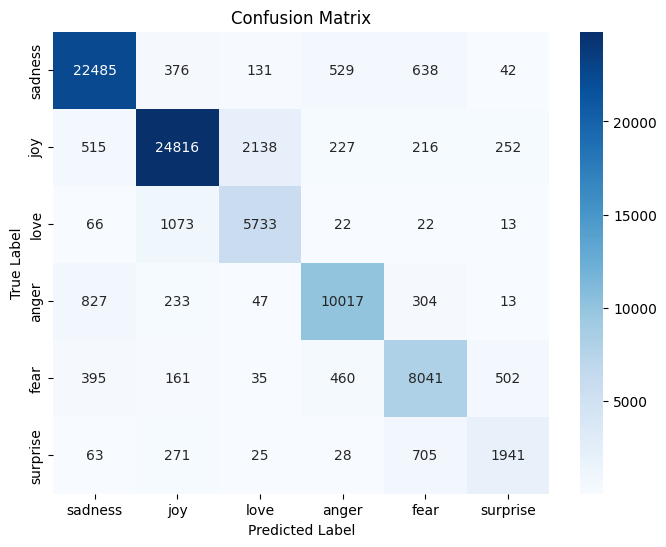

In [47]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [48]:
# Function to predict custom sentence
def predict_custom_sentence(sentence):
    preprocessed_sentence = preprocess_text(sentence)
    sequence = tokenizer.texts_to_sequences([preprocessed_sentence])
    padded_sequence = pad_sequences(sequence, maxlen=maxlen)
    prediction = model.predict(padded_sequence)
    predicted_class = class_names[tf.argmax(prediction, axis=1).numpy()[0]]
    return predicted_class

In [49]:
# Test the model with a custom sentence
custom_sentence = "I am very happy with the current situation"
predicted_class = predict_custom_sentence(custom_sentence)
print(f"\nCustom Sentence: '{custom_sentence}'\nPredicted Class: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step

Custom Sentence: 'I am very happy with the current situation'
Predicted Class: joy


W0000 00:00:1718545458.243807     258 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [50]:
custom_sentence = "si would think that whomever would be lucky enough to stay in this suite must feel like it is the most romantic place on earth"
predicted_class = predict_custom_sentence(custom_sentence)
print(f"\nCustom Sentence: '{custom_sentence}'\nPredicted Class: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Custom Sentence: 'si would think that whomever would be lucky enough to stay in this suite must feel like it is the most romantic place on earth'
Predicted Class: love


In [51]:
custom_sentence = "i think that after i had spent some time investigating the surroundings and things i started to feel more curious about other people"
predicted_class = predict_custom_sentence(custom_sentence)
print(f"\nCustom Sentence: '{custom_sentence}'\nPredicted Class: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Custom Sentence: 'i think that after i had spent some time investigating the surroundings and things i started to feel more curious about other people'
Predicted Class: surprise


In [52]:
custom_sentence = "i am not bored i feel relaxed on the verge of possible sleep"
predicted_class = predict_custom_sentence(custom_sentence)
print(f"\nCustom Sentence: '{custom_sentence}'\nPredicted Class: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

Custom Sentence: 'i am not bored i feel relaxed on the verge of possible sleep'
Predicted Class: joy


In [53]:
custom_sentence = "si walked away feeling oddly dissatisfied"
predicted_class = predict_custom_sentence(custom_sentence)
print(f"\nCustom Sentence: '{custom_sentence}'\nPredicted Class: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Custom Sentence: 'si walked away feeling oddly dissatisfied'
Predicted Class: anger


In [54]:
custom_sentence = "i feel very much content with what my kids know and learned so far at this time"
predicted_class = predict_custom_sentence(custom_sentence)
print(f"\nCustom Sentence: '{custom_sentence}'\nPredicted Class: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

Custom Sentence: 'i feel very much content with what my kids know and learned so far at this time'
Predicted Class: joy
